## Setup

In [ ]:
!nvidia-smi

Tue Jun 28 17:17:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.autograd import Variable 

#!pip install pandas==1.3.0 #1.3.0
import pandas as pd

import glob
!pip3 install pickle5
import pickle5 as pickle
import os

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
#from pandas.core.computation.check import NUMEXPR_INSTALLED

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 33.0 MB/s 


### Five Key Steps
#### 1. Load and normalize the train and test data 
#### 2.Define the Convolutional Neural Network (CNN)
#### 3. Define the loss function and optimizer
#### 4. Train the model on the train data
#### 5. Test the model on the test data

In [ ]:
#Mount Drive to get data
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#set the device to cuda:0 
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

## Dataset

In [ ]:
#Load In the Dataset
class EEGDataset(Dataset):

  def __init__(self, data_path, chunk_size=1000):
    """
        Args:
            data_path (string): Directory with the EEG training data. Filenames in this dir must begin with "PD" or "Control" to assign labels correctly. Must be in .csv files. 
            chunk_size (int): Number of datapoints from EEG time series to be included in a single non-overlapping epoch. Note that UNM data was collected at 500Hz.
    """
    #create a list of datafields to keep. The electrodes given here are those in common to both the UI and UNM datasets.
    self.common_electrodes = ['time', 'Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'POz', 'PO8', 'P6', 'P2', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']

    #create the datapaths
    self.data_path = data_path  
    self.data_list = glob.glob(self.data_path + "*.csv")

    #create containers for the data and labels respectively
    self.df_list = []
    self.label_list = []

    self.files = glob.glob(self.data_path+ '*.csv')

    for file in self.files:

      if os.path.isfile(file):
        csv = pd.read_csv(file,sep=',', index_col=[0])#load in single session as a csv
        csv = csv.drop(index=0, inplace=False, axis=0) #drop first row because it's usually noisy
        csv = csv[self.common_electrodes]             #select the subset of electrodes defined by self.common_electrodes
        csv = csv.drop('time', inplace=False, axis=1) #drop time so it is not considered as a variable

         #csv is then segmented into epochs. Each epochs is added as a df to the list of data with a corresponding list of labels (at this point the whole filename is given as the label).
        for chunk in range(1,csv.shape[0]//chunk_size +1):
            start = (chunk-1)*chunk_size
            stop = chunk*chunk_size
            self.df_list.append(csv.iloc[start:stop])
            self.label_list.append(file)

    print('there are this many items in the list of data ' ,len(self.df_list))  
    print('there are this many items in the list of labels ' , len(self.label_list))

    #define the labels as vectors to match training
    self.class_map = {"CTL" : [0, 1], "PD": [1, 0]} 
    
    #Normalize each channel of each epoch to a mean of 0 and std of 1.
    self.all_data = self.df_list[0]
    
    self.normalized_df_list = []
    
    #iterate through each epoch
    for df_index in range(0,len(self.df_list)):
      
      temp_df = self.df_list[df_index]
      mean_by_channel = []
      std_by_channel = []
      
      #determine normalization parameters by column (i.e. for each channel)
      for column in temp_df:
        mean_by_channel.append(temp_df[column].mean())
        std_by_channel.append(temp_df[column].std())

      #apply normalization
      temp_df = temp_df.sub(mean_by_channel, axis='columns')
      temp_df = temp_df.div(std_by_channel, axis='columns')
      self.normalized_df_list.append(temp_df)

    assert (len(std_by_channel)== len(mean_by_channel)), 'length of mean normalization and std normalization are not same length'
    print('The length of the lists of channels means and stds is ', len(mean_by_channel))
    assert ((self.normalized_df_list[0].shape)==(self.df_list[0].shape) and (len(self.normalized_df_list)==len(self.df_list))), 'Normalization changed the shape of the df_list'
      

    #this is a required function that tells you how many data points you have in the dataset
  def __len__(self):
      return len(self.normalized_df_list) 

  #this is a required function that allows you to obtain a single data point according to its index
  def __getitem__(self, idx):
    
    #each dataframe represents one block id
    eeg_dataframe = self.normalized_df_list[idx]
    
    #determine whether that subject is control or PD
    filename = self.label_list[idx].split('/')[-1]
    # this is the string containing the filename. index first 2 chars to see if PD.
    if filename[0:2]=='PD':
      PD_label = 'PD'
    # then see if its control
    elif filename[0:7]=='Control':
      PD_label = 'CTL'
    # if neither, throw an error
    else:
      print(self.label_list[idx][0:2])
      print(self.label_list[idx][0:7])
      assert False, 'there is a problem finding the label'

    #convert label to tensor using class map
    PD_label = torch.tensor(self.class_map[PD_label], dtype=torch.long)
    
   
    #reformat the eeg data
    eeg_tensor = torch.tensor(eeg_dataframe[0:chunk_size].values) #you can artificially shorten epochs here
    eeg_tensor = torch.permute(eeg_tensor,(1, 0))
    
    
    return eeg_tensor.float(), PD_label.float()


## Define the Neural Network

In [ ]:
class PDNet(nn.Module):

    def __init__(self,chunk_size=2500):
        super(PDNet, self).__init__()
        self.chunk_size = chunk_size

        self.conv1 = nn.Conv1d(in_channels=60, out_channels=21, kernel_size=20,stride=1)
        self.norm1 = nn.BatchNorm1d(num_features=21)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv2 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=10,stride=1)
        self.norm2 = nn.BatchNorm1d(num_features=42)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv3 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=10,stride=1)
        self.norm3 = nn.BatchNorm1d(num_features=42)
        self.maxpool3 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv4 = nn.Conv1d(in_channels=42, out_channels=64, kernel_size=5,stride=1)
        self.norm4 = nn.BatchNorm1d(num_features=64)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4,stride=4)

        
        self.relu = nn.LeakyReLU(0.1)

        
        self.fc1 = nn.Linear(in_features=448,out_features=256)#in_features=4*(self.chunk_size-8)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.relu(self.maxpool1(self.norm1(self.conv1(x))))

        x = self.relu(self.maxpool2(self.norm2(self.conv2(x))))
        
        x = self.relu(self.maxpool3(self.norm3(self.conv3(x))))
        
        x = self.relu(self.maxpool4(self.norm4(self.conv4(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimensi
        
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(self.fc4(x))
        return x


In [ ]:
#test the input and output shapes
input_tensor = torch.rand([8,60,2500]).cuda() #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
network = PDNet().cuda()
output_tensor = network(input_tensor)
print((output_tensor.shape))


torch.Size([8, 60, 2500])
torch.Size([8, 2])


## Train and Validate Methods

In [ ]:
def train(model,train_dataloader, epochs=30, learning_rate=0.0001, num_workers=2, training_loss_tracker=[], val_loss_tracker=[]):
    '''
    INPUTS:
      model(nn.Module): here we will pass PDNet to the training loop. 
      valloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the validation batches. 
      threshold(float): give a threshold above which a classification will be binarized to PD and below to CTL
      batch_size(int): batch size of the valloader
      supress_output(bool): False to get output print statements
    
    OUTPUTS:
      model(nn.Module): updated, trained model.
    '''
    assert epochs > len(training_loss_tracker), 'Loss tracker is already equal to or greater than epochs'

    #define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5,0.5]).cuda())
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #start a timer
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    current_epoch = 0 
    counter = 0
    

    for epoch in range(current_epoch, epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        counter = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
            
            batch_size = inputs.shape[0]

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward 
            outputs = model(inputs)

            
            #regularization #Replace pow(2.0) with abs() for L1 regularization
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                  
            # calculate loss
            loss = criterion(outputs,labels) + l2_lambda*l2_norm

            #backward + optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            counter += 1
          
    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()

    return model 

In [ ]:
#testing the performance
def validate(model, valloader,threshold=0.5,batch_size=8):

  total_loss = 0
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0


  outputs = []
  true_labels = []
  counter = 0

  #This loads a batch at time
  for i, data in enumerate(valloader, 0):

    #read in data
    inputs, labels = data
    inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
    
    #forward
    output = model(inputs)

    #calculate loss + regularization
    criterion = nn.CrossEntropyLoss() 
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    total_loss += criterion(output,labels) + l2_lambda*l2_norm
    counter += 1

    #binarize output based on threshold
    output[output>threshold] = 1
    output[output<threshold] = 0

    #determine whether each classification was true/false and positive/negative
    for j in range(0,len(output)):
      if (output[j-1,0] == 1) and (labels[j-1,0] == 1):
          true_positives += 1
      elif(output[j-1,0]==1) and (labels[j-1,0] == 0):
          false_positives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 1):
          false_negatives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 0):
          true_negatives += 1
  
    
  avg_loss = total_loss/counter 
  print("the average validation loss value is: ", avg_loss.item())
  

  return true_positives, false_positives, true_negatives, false_negatives

## Dataleak Experiment

To mimic the cross validation at the epoch level, I will need to perform 52 folds with K = N_samples/52. I perform this experiment with replacement. 

In [ ]:
####################### Make Dataset ###########################################
batch_size = 8
num_workers = 2
chunk_size = 2500

#data locations for full train/val data
data_src = '/content/drive/MyDrive/UNM_Data/' #full

#load in the EEG dataset
EEG_Dataset = EEGDataset(data_path=data_src, chunk_size=chunk_size)


there are this many items in the list of data  2122
there are this many items in the list of labels  2122
The length of the lists of channels means and stds is  60


In [ ]:
'''
  This cell will create a new train/test split based {folds} number of times. It will train and validate for each train/test split. 
'''
N_samples = len(EEG_Dataset)
folds = 52 #how many iterations of training and validation do you want to run. 52 is chosen to be comparable to our CV codes
K = N_samples/folds 
val_size = int(np.round(K))
train_size= int(N_samples - val_size)

true_positives, false_positives, true_negatives, false_negatives = 0, 0, 0, 0


for i in range(folds):
  print(' Starting Fold # ', i)
  #define the train test split
  train_dataset, val_dataset = random_split(EEG_Dataset, [train_size, val_size],generator=torch.Generator().manual_seed(i))

  #create a respective dataloader out of the test/train split
  trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  valloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers=num_workers)

  #initialize model
  model = PDNet(chunk_size=chunk_size).to(device)
  model.train()

  #run train which will in turn run validate. they return the confusion matrix which will get saved here. 
  model = train(model=model,train_dataloader=trainloader, epochs=30, learning_rate=0.0001, training_loss_tracker=[], val_loss_tracker=[])
  model.eval()
  TP, FP, TN, FN = validate(model, valloader=valloader,threshold=0.5,batch_size=batch_size)

  print('true positives: ', TP)
  print('false positives: ',FP)
  print('true negatives: ',TN)
  print('false negatives', FN)  

  true_positives += TP
  false_positives += FP
  true_negatives += TN
  false_negatives += FN
  print('----------------------------------------------------------')

print('total True Positives: ', true_positives)
print('total False Positives: ', false_positives)
print('total True Negatives: ', true_negatives)
print('total False Negatives: ', false_negatives)


 Starting Fold #  0
the average validation loss value is:  0.39870738983154297
true positives:  14
false positives:  0
true negatives:  23
false negatives 4
----------------------------------------------------------
 Starting Fold #  1
the average validation loss value is:  0.40237098932266235
true positives:  23
false positives:  4
true negatives:  14
false negatives 0
----------------------------------------------------------
 Starting Fold #  2
the average validation loss value is:  0.35075148940086365
true positives:  14
false positives:  0
true negatives:  26
false negatives 1
----------------------------------------------------------
 Starting Fold #  3
the average validation loss value is:  0.3884269595146179
true positives:  19
false positives:  3
true negatives:  19
false negatives 0
----------------------------------------------------------
 Starting Fold #  4
the average validation loss value is:  0.3614847660064697
true positives:  22
false positives:  2
true negatives:  17

## Evaluation

In [ ]:
def plot_confusion_matrix(TP, FP, TN, FN):
  pred = []
  true = []

  for i in range(TP):
    pred.append(1)
    true.append(1)
  
  for i in range(FP):
    pred.append(1)
    true.append(0)
  
  for i in range(TN):
    pred.append(0)
    true.append(0)

  for i in range(FN):
    pred.append(0)
    true.append(1)

  plt.figure(figsize=(8,6))
  conf_matrix = (confusion_matrix(true, pred))
  # Using Seaborn heatmap to create the plot
  fx = sns.heatmap(conf_matrix,cmap='vlag',annot=True, annot_kws={'fontsize':15},fmt='g')
  
  # labels the title and x, y axis of plot
  #fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
  fx.set_xlabel('Predicted Values',size=16)
  fx.set_ylabel('Actual Values ', size=16);

  # labels the boxes
  fx.xaxis.set_ticklabels(['CTL','PD'],size=15)
  fx.yaxis.set_ticklabels(['CTL','PD'],size=15)

  plt.show()

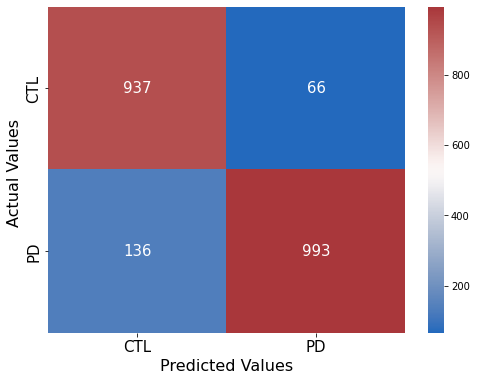

In [ ]:
plot_confusion_matrix(TP=993, FP=66, TN=937, FN=136)

## Chi Square Test

In [ ]:
from scipy.stats import chisquare

def run_chi_squared_test(TP, FP, TN, FN):
  chisq, p_value = chisquare([TP, FP, TN, FN])

  return chisq, p_value


In [ ]:
x2, p = run_chi_squared_test(TP=384, FP=128, TN=398, FN=132)
print(p)

1.7381685820516554e-56


In [ ]:
#run validation
#model = ParkNetCNN().to(device)
model.eval()
validate(model=model,valloader=valloader,threshold=0.5,batch_size=batch_size)


#for threshold in [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]:
  #validate(model=model,valloader=valloader,threshold=threshold,batch_size=batch_size)
  #print('-------')

true positives:  31
false positives:  1
true negatives:  10
false negatives 1
the average validation loss value is:  0.4098684787750244
The F1 Manual Calculation score was  0.96875
--------------------------------------------------


0.4098684787750244

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


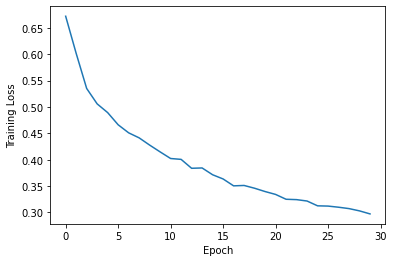

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


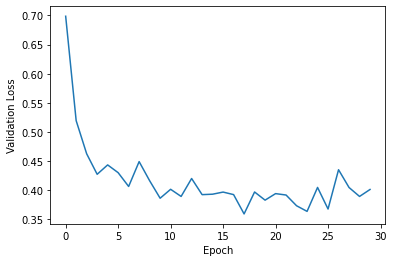

In [ ]:
#display training loss as a result
training_loss = sns.lineplot(np.arange(0,len(log_containing_train_loss)), log_containing_train_loss) 
_ = training_loss.set_xlabel('Epoch')
_ = training_loss.set_ylabel('Training Loss')
plt.show()
validation_loss = sns.lineplot(np.arange(0,len(log_containing_val_loss)), log_containing_val_loss) 
_ = validation_loss.set_xlabel('Epoch')
_ = validation_loss.set_ylabel('Validation Loss')
plt.show()